TRAIN - 骨质疏松: 391, 非骨质疏松: 749, 总样本: 1140
TEST - 骨质疏松: 48, 非骨质疏松: 95, 总样本: 143
VAL - 骨质疏松: 49, 非骨质疏松: 95, 总样本: 144
EXTEST - 骨质疏松: 38, 非骨质疏松: 65, 总样本: 103

========== Epoch 1/5 ==========
TRAIN  | ACC=0.7851  AUC=0.8910 (95%CI 0.8714-0.9094)  Prec=0.8967  Spec=0.9746  Rec=0.4220  F1=0.5739
TEST   | ACC=0.7203  AUC=0.7732 (95%CI 0.6832-0.8575)  Prec=0.7857  Spec=0.9684  Rec=0.2292  F1=0.3548
VAL    | ACC=0.7778  AUC=0.7966 (95%CI 0.7159-0.8729)  Prec=0.9048  Spec=0.9789  Rec=0.3878  F1=0.5429
EXTEST | ACC=0.6893  AUC=0.8498 (95%CI 0.7705-0.9161)  Prec=0.7500  Spec=0.9538  Rec=0.2368  F1=0.3600

========== Epoch 2/5 ==========
TRAIN  | ACC=0.8667  AUC=0.9223 (95%CI 0.9056-0.9381)  Prec=0.8918  Spec=0.9559  Rec=0.6957  F1=0.7816
TEST   | ACC=0.7343  AUC=0.7726 (95%CI 0.6895-0.8475)  Prec=0.7083  Spec=0.9263  Rec=0.3542  F1=0.4722
VAL    | ACC=0.7153  AUC=0.7482 (95%CI 0.6630-0.8239)  Prec=0.6111  Spec=0.8526  Rec=0.4490  F1=0.5176
EXTEST | ACC=0.7379  AUC=0.8113 (95%CI 0.7143-0.8934)  Prec=

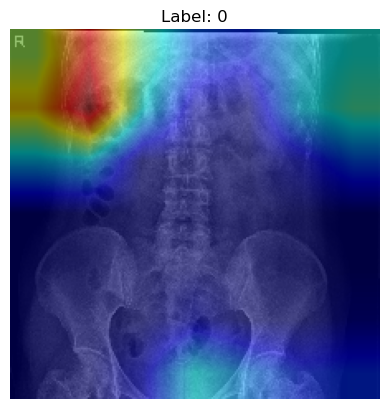

In [1]:
# train_osteoporosis.py
import os
import pandas as pd
import numpy as np
import pydicom
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.metrics import (
    roc_auc_score, roc_curve, accuracy_score,
    precision_recall_fscore_support, recall_score
)
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import warnings
warnings.filterwarnings("ignore")

# ------------------ 全局配置 ------------------
device = torch.device("cpu")
batch_size = 4
num_epochs = 5
learning_rate = 1e-4
image_size = 224

base_path = "D:/骨密度数据集"
table_paths = {
    'train':  os.path.join(base_path, 'train_table.xlsx'),
    'test':   os.path.join(base_path, 'test_table.xlsx'),
    'val':    os.path.join(base_path, 'val_table.xlsx'),
    'extest': os.path.join(base_path, 'extest_table.xlsx')
}
image_dirs = {
    'train':  os.path.join(base_path, 'train'),
    'test':   os.path.join(base_path, 'test'),
    'val':    os.path.join(base_path, 'val'),
    'extest': os.path.join(base_path, 'extest')
}

# ------------------ 工具函数 ------------------
def load_clean_table(path, image_dir):
    df = pd.read_excel(path)
    if '编号' in df.columns:
        df.rename(columns={'编号': 'ID'}, inplace=True)
    df['ID'] = df['ID'].astype(str)
    df = df[df['ID'].apply(
        lambda pid: os.path.isfile(os.path.join(image_dir, str(pid), 'zw.dcm'))
    )].reset_index(drop=True)
    counts = df['是否骨质疏松'].value_counts()
    return df, counts

class BoneDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        pid = str(row['ID'])
        label = int(row['是否骨质疏松'])
        dcm_path = os.path.join(self.image_dir, pid, 'zw.dcm')
        ds = pydicom.dcmread(dcm_path)
        image = ds.pixel_array.astype(np.float32)
        image = (image - image.min()) / (image.max() - image.min() + 1e-8)
        if image.ndim == 2:
            image = np.stack([image]*3, axis=0)
        image = torch.tensor(image).unsqueeze(0)
        image = torch.nn.functional.interpolate(image, size=(image_size, image_size)).squeeze(0)
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0]==1 else x)
])

# ------------------ 加载数据 ------------------
stats = {}
for split in ['train', 'test', 'val', 'extest']:
    df, counts = load_clean_table(table_paths[split], image_dirs[split])
    stats[split] = {'df': df, 'counts': counts}
    print(f"{split.upper()} - 骨质疏松: {counts.get(1,0)}, 非骨质疏松: {counts.get(0,0)}, 总样本: {len(df)}")

loaders = {}
for split in ['train', 'test', 'val', 'extest']:
    dataset = BoneDataset(stats[split]['df'], image_dirs[split], transform=transform)
    loaders[split] = DataLoader(dataset, batch_size=batch_size, shuffle=(split=='train'), num_workers=0)

# ------------------ 模型 ------------------
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# ------------------ 评估函数 ------------------
def evaluate(loader):
    model.eval()
    all_labels, all_probs = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.float().to(device)
            outputs = model(images).squeeze(1)
            probs = torch.sigmoid(outputs)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_labels, all_probs = np.array(all_labels), np.array(all_probs)
    if len(all_labels) == 0:
        return None
    preds = (all_probs >= 0.5).astype(int)
    acc  = accuracy_score(all_labels, preds)
    auc  = roc_auc_score(all_labels, all_probs)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, preds, average='binary', zero_division=0)
    specificity = recall_score(1 - all_labels, 1 - preds, average='binary', zero_division=0)
    return acc, auc, precision, specificity, recall, f1, all_labels, all_probs

# ------------------ Bootstrap AUC 95% CI ------------------
def bootstrap_auc_ci(y_true, y_score, n_boot=2000, ci=0.95, rng_seed=42):
    rng = np.random.default_rng(rng_seed)
    aucs = []
    n = len(y_true)
    for _ in range(n_boot):
        idx = rng.integers(0, n, n)
        try:
            aucs.append(roc_auc_score(y_true[idx], y_score[idx]))
        except ValueError:
            continue
    aucs = np.array(aucs)
    lower, upper = np.percentile(aucs, [(1-ci)/2*100, (1+ci)/2*100])
    return roc_auc_score(y_true, y_score), lower, upper

# ------------------ 训练循环（每 epoch 画 ROC + CI） ------------------
metrics_ci_log = []   # 保存所有 epoch 所有 split 的 CI
for epoch in range(num_epochs):
    # ---------- 1. 训练 ----------
    model.train()
    for images, labels in loaders['train']:
        images, labels = images.to(device), labels.float().to(device)
        outputs = model(images).squeeze(1)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # ---------- 2. 评估 & 绘图 ----------
    print(f"\n========== Epoch {epoch+1}/{num_epochs} ==========")
    plt.figure(figsize=(8, 6))

    for split in ['train', 'test', 'val', 'extest']:
        loader = loaders[split]
        if len(loader.dataset) == 0:
            print(f"⚠️ 跳过空数据集：{split}")
            continue

        res = evaluate(loader)
        if res is None:
            continue
        acc, auc, prec, spec, rec, f1, labels, probs = res
        fpr, tpr, _ = roc_curve(labels, probs)
        auc_obs, lower, upper = bootstrap_auc_ci(labels, probs)

        # 控制台打印
        print(f"{split.upper():6} | "
              f"ACC={acc:.4f}  AUC={auc:.4f} (95%CI {lower:.4f}-{upper:.4f})  "
              f"Prec={prec:.4f}  Spec={spec:.4f}  Rec={rec:.4f}  F1={f1:.4f}")

        # 画 ROC
        plt.plot(fpr, tpr,
                 label=f"{split}  AUC={auc:.3f} [{lower:.3f}-{upper:.3f}]")

    # ---------- 3. 保存图 ----------
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves - Epoch {epoch+1}")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig(f"roc_epoch_{epoch+1}.png", dpi=300)
    plt.close()

    # ---------- 4. 记录 ----------
    epoch_ci = {'epoch': epoch + 1}
    for split in ['train', 'test', 'val', 'extest']:
        res = evaluate(loaders[split])
        if res is None:
            epoch_ci.update({
                f'{split}_auc': np.nan,
                f'{split}_ci_lower': np.nan,
                f'{split}_ci_upper': np.nan
            })
        else:
            _, auc, _, _, _, _, labels, probs = res
            _, lower, upper = bootstrap_auc_ci(labels, probs)
            epoch_ci.update({
                f'{split}_auc': auc,
                f'{split}_ci_lower': lower,
                f'{split}_ci_upper': upper
            })
    metrics_ci_log.append(epoch_ci)

# 汇总所有 epoch CI
pd.DataFrame(metrics_ci_log).to_csv('auc_ci_per_epoch.csv', index=False, encoding='utf-8-sig')
print("\n所有 epoch 的 AUC 95% CI 已保存到 auc_ci_per_epoch.csv")

# ------------------ Grad-CAM 可视化 ------------------
def visualize_cam(image_tensor, label):
    model.eval()
    target_layer = model.layer4[-1].conv2
    cam = GradCAM(model=model, target_layers=[target_layer])
    grayscale_cam = cam(input_tensor=image_tensor.unsqueeze(0), targets=None)[0]
    img_np = image_tensor.permute(1, 2, 0).numpy()
    visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)
    plt.imshow(visualization)
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

sample_img, sample_label = next(iter(loaders['test']))
visualize_cam(sample_img[0], sample_label[0])

In [2]:
# ====================== 计算平均预测概率 + 平均 ROC ======================
print("\n========== 计算平均预测概率 & 平均 ROC ==========")
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
sns.set_style("whitegrid")

# 存储每个 split 的平均结果
average_results = {}

plt.figure(figsize=(6, 6))

for split in ['train', 'test', 'val', 'extest']:
    loader = loaders[split]
    if len(loader.dataset) == 0:
        continue

    model.eval()
    all_labels, all_probs = [], []

    # 重新跑一次，收集全部样本的平均概率
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.float().to(device)
            outputs = model(images).squeeze(1)
            probs = torch.sigmoid(outputs)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_probs  = np.array(all_probs)

    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    auc_val = roc_auc_score(all_labels, all_probs)
    _, lower, upper = bootstrap_auc_ci(all_labels, all_probs)

    average_results[split] = {
        'fpr': fpr, 'tpr': tpr, 'auc': auc_val,
        'ci_lower': lower, 'ci_upper': upper
    }

    plt.plot(fpr, tpr, label=f"{split} (AUC={auc_val:.3f})")
    print(f"{split.upper():6} | AUC={auc_val:.4f} (95% CI {lower:.4f}-{upper:.4f})")

# 画对角线 & 保存
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Average ROC Curves (after training)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("average_roc.png", dpi=300)
plt.close()
print("\n平均 ROC 曲线已保存为 average_roc.png")


========== 计算平均预测概率 & 平均 ROC ==========
TRAIN  | AUC=0.9976 (95% CI 0.9959-0.9989)
TEST   | AUC=0.8263 (95% CI 0.7471-0.8958)
VAL    | AUC=0.8567 (95% CI 0.7890-0.9173)
EXTEST | AUC=0.8186 (95% CI 0.7256-0.8947)

平均 ROC 曲线已保存为 average_roc.png


In [3]:
# ====================== 计算各指标平均值 + 95% CI ======================
print("\n========== 各数据集指标平均值 & 95% CI ==========")

from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support, recall_score
import pandas as pd

# 需要计算的指标
metrics_names = ['ACC', 'AUC', 'Precision', 'Specificity', 'Recall', 'F1']

# 存储结果
summary = []

for split in ['train', 'test', 'val', 'extest']:
    loader = loaders[split]
    if len(loader.dataset) == 0:
        continue

    model.eval()
    all_labels, all_probs = [], []

    # 收集全部样本
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.float().to(device)
            outputs = model(images).squeeze(1)
            probs = torch.sigmoid(outputs)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_probs  = np.array(all_probs)
    preds = (all_probs >= 0.5).astype(int)

    # ---------- 计算指标 ----------
    acc  = accuracy_score(all_labels, preds)
    auc  = roc_auc_score(all_labels, all_probs)
    prec, rec, f1, _ = precision_recall_fscore_support(
        all_labels, preds, average='binary', zero_division=0)
    spec = recall_score(1 - all_labels, 1 - preds, average='binary', zero_division=0)

    # ---------- Bootstrap 计算 95% CI ----------
    rng = np.random.default_rng(42)
    n_boot = 2000
    ci_dict = {m: [] for m in metrics_names}

    for _ in range(n_boot):
        idx = rng.integers(0, len(all_labels), len(all_labels))
        y_true_b = all_labels[idx]
        y_pred_b = preds[idx]
        y_prob_b = all_probs[idx]

        try:
            ci_dict['ACC'].append(accuracy_score(y_true_b, y_pred_b))
            ci_dict['AUC'].append(roc_auc_score(y_true_b, y_prob_b))
            p, r, f, _ = precision_recall_fscore_support(
                y_true_b, y_pred_b, average='binary', zero_division=0)
            ci_dict['Precision'].append(p)
            ci_dict['Recall'].append(r)
            ci_dict['F1'].append(f)
            ci_dict['Specificity'].append(
                recall_score(1 - y_true_b, 1 - y_pred_b, average='binary', zero_division=0))
        except ValueError:
            continue

    # ---------- 整理结果 ----------
    row = {'Dataset': split.upper()}
    for m in metrics_names:
        mean_val = {'ACC': acc, 'AUC': auc,
                    'Precision': prec, 'Specificity': spec,
                    'Recall': rec, 'F1': f1}[m]
        lower, upper = np.percentile(ci_dict[m], [2.5, 97.5])
        row[m] = f"{mean_val:.4f} [{lower:.4f}-{upper:.4f}]"
    summary.append(row)

# ---------- 打印表格 ----------
df_summary = pd.DataFrame(summary).set_index('Dataset')
print(df_summary.to_string())


========== 各数据集指标平均值 & 95% CI ==========
                            ACC                     AUC               Precision             Specificity                  Recall                      F1
Dataset                                                                                                                                                
TRAIN    0.9807 [0.9719-0.9877]  0.9976 [0.9960-0.9989]  0.9601 [0.9378-0.9779]  0.9786 [0.9673-0.9882]  0.9847 [0.9713-0.9950]  0.9722 [0.9588-0.9828]
TEST     0.7552 [0.6783-0.8182]  0.8263 [0.7471-0.8958]  0.6327 [0.4918-0.7609]  0.8105 [0.7317-0.8866]  0.6458 [0.5094-0.7826]  0.6392 [0.5176-0.7477]
VAL      0.8194 [0.7569-0.8750]  0.8567 [0.7890-0.9173]  0.7447 [0.6170-0.8571]  0.8737 [0.8061-0.9346]  0.7143 [0.5909-0.8372]  0.7292 [0.6185-0.8205]
EXTEST   0.7476 [0.6602-0.8252]  0.8186 [0.7256-0.8947]  0.6500 [0.5000-0.7941]  0.7846 [0.6774-0.8788]  0.6842 [0.5263-0.8286]  0.6667 [0.5294-0.7734]


In [4]:
# ====================== 保存每个患者的完整预测结果 ======================
print("\n========== 保存每个患者的完整预测结果 ==========")

import csv

threshold = 0.5   # 如需调整阈值，改这里

for split in ['train', 'test', 'val', 'extest']:
    loader = loaders[split]
    if len(loader.dataset) == 0:
        continue

    model.eval()
    results = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images).squeeze(1)
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs >= threshold).astype(int)

            batch_df = stats[split]['df'].iloc[len(results):len(results)+len(images)]
            for pid, true_l, p, pred_l in zip(
                    batch_df['ID'].astype(str),
                    labels.cpu().numpy(),
                    probs,
                    preds):
                results.append([pid, int(true_l), f"{p:.6f}", int(pred_l)])

    csv_path = f"{split}_full_results.csv"
    with open(csv_path, 'w', newline='', encoding='utf-8-sig') as f:
        writer = csv.writer(f)
        writer.writerow(['ID', 'true_label', 'pred_prob', 'pred_label'])
        writer.writerows(results)

    print(f"{split.upper()} 已保存：{csv_path}，共 {len(results)} 条记录")


========== 保存每个患者的完整预测结果 ==========
TRAIN 已保存：train_full_results.csv，共 1140 条记录
TEST 已保存：test_full_results.csv，共 143 条记录
VAL 已保存：val_full_results.csv，共 144 条记录
EXTEST 已保存：extest_full_results.csv，共 103 条记录
